## 최신 기출동형 모의고사 - 제3회 기출동형 모의고사
### 1. 머신러닝 (50점)

#### (1) 데이터를 탐색하고 탐색 결과를 제시하시오.

In [38]:
import pandas as pd
import numpy as np 
import pandas.api.types as type
import matplotlib.pyplot as plt
from scipy.stats import zscore

plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (20, 4)
plt.rcParams['axes.unicode_minus'] = False

hotel = pd.read_csv('../data/hotel_bookings.csv')

hotel.is_canceled = hotel.is_canceled.astype('category')
hotel.is_repeated_guest = hotel.is_repeated_guest.astype('category')

hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   is_canceled                     20000 non-null  category
 1   deposit_type                    20000 non-null  object  
 2   lead_time                       19995 non-null  float64 
 3   stays_in_weekend_nights         20000 non-null  int64   
 4   stays_in_week_nights            20000 non-null  int64   
 5   is_repeated_guest               19642 non-null  category
 6   previous_cancellations          20000 non-null  int64   
 7   previous_bookings_not_canceled  20000 non-null  int64   
 8   booking_changes                 20000 non-null  int64   
 9   days_in_waiting_list            20000 non-null  int64   
 10  adr                             18937 non-null  float64 
dtypes: category(2), float64(2), int64(6), object(1)
memory usage: 1.4+ MB


* Data distribution and outliers -----------


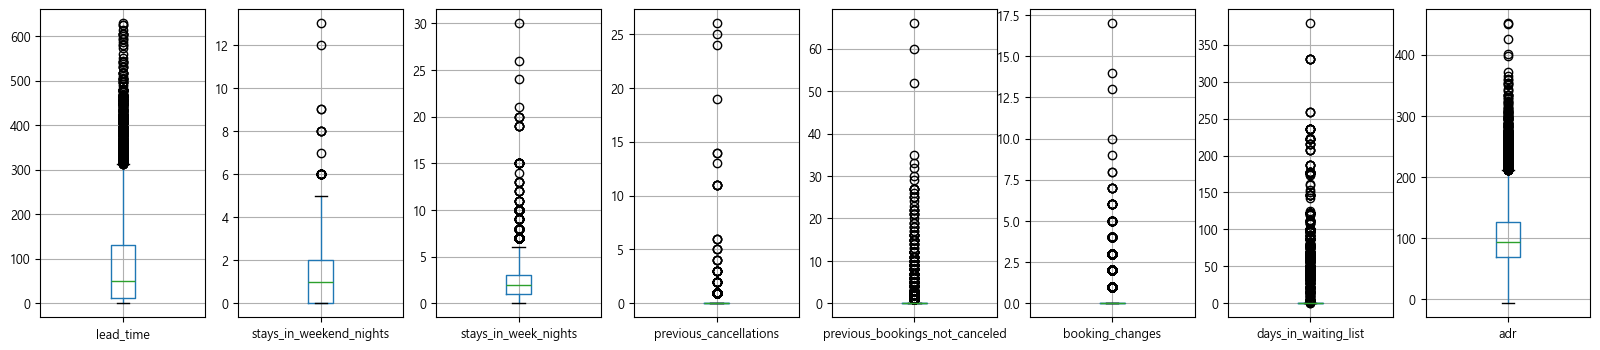

* Columns and Data types -------------------


,column,dtype,NA_counts,Value_counts,outlier_counts,min,mean,max
0,is_canceled,category,0.0,2.0,NaN,NaN,NaN,NaN
1,deposit_type,object,0.0,3.0,NaN,NaN,NaN,NaN
2,lead_time,float64,5.0,442.0,350.0,0.00,85.978345,629.0
3,stays_in_weekend_nights,int64,0.0,12.0,271.0,0.00,0.892550,13.0
4,stays_in_week_nights,int64,0.0,22.0,274.0,0.00,2.380400,30.0
5,is_repeated_guest,category,358.0,2.0,NaN,NaN,NaN,NaN
6,previous_cancellations,int64,0.0,14.0,51.0,0.00,0.032900,26.0
7,previous_bookings_not_canceled,int64,0.0,36.0,204.0,0.00,0.169050,66.0
8,booking_changes,int64,0.0,14.0,306.0,0.00,0.269400,17.0
9,days_in_waiting_list,int64,0.0,98.0,320.0,0.00,1.983950,379.0


In [39]:
def describe_ext(df):
    colsdf = pd.DataFrame()
    num_cols = []
    cat_cols = []

    for i, col in enumerate(df.columns) :
        colsdf.loc[i, 'column'] = col
        colsdf.loc[i, 'dtype'] = str(df[col].dtype)
        colsdf.loc[i, 'NA_counts'] = df[col].isna().sum()
        colsdf.loc[i, 'Value_counts'] = df[col].value_counts().size
        if type.is_numeric_dtype(df[col].dtype) : 
            num_cols.append(col)
            temp = df[col].dropna()
            colsdf.loc[i, 'outlier_counts'] = temp[np.abs(zscore(temp))>3].size
            colsdf.loc[i, 'min'] = df[col].min()
            colsdf.loc[i, 'mean'] = df[col].mean()
            colsdf.loc[i, 'max'] = df[col].max()
        else:
            cat_cols.append(col)
    
    return colsdf, num_cols, cat_cols

print('* Data distribution and outliers -----------')
colsdf = pd.DataFrame()
num_cols = []
cat_cols = []
colsdf, num_cols, cat_cols = describe_ext(hotel)

fig, ax = plt.subplots(1, len(num_cols))
for i, col in enumerate(num_cols):
    hotel.boxplot(column=col, ax=ax[i])
plt.show()

print('* Columns and Data types -------------------')
colsdf

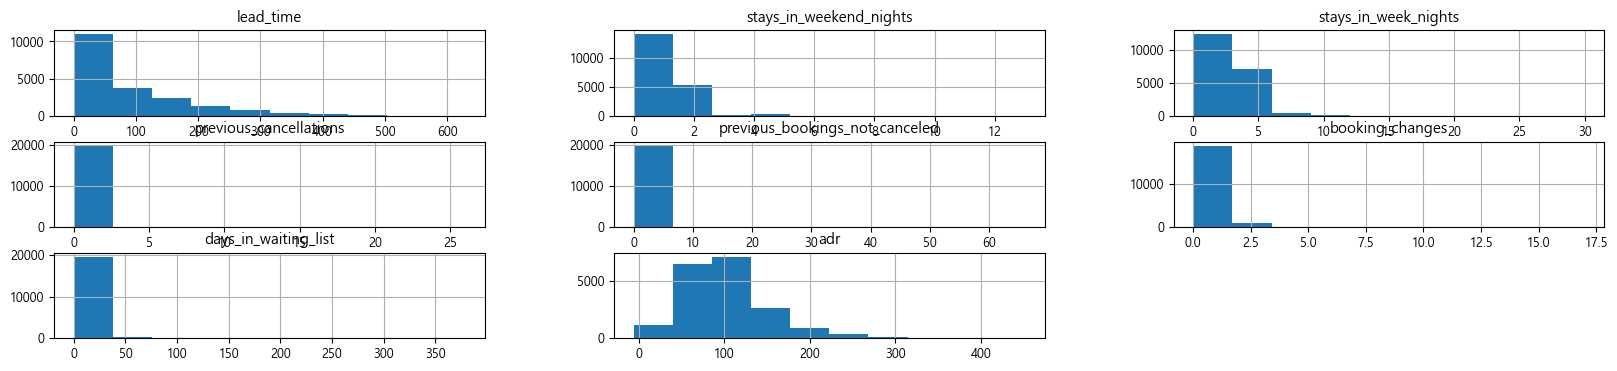

In [40]:
hotel.hist()
plt.show()

#### (2) 결측치를 탐색하고 대체 방법 및 근거를 제시하시오.

In [41]:
print(cat_cols)
print(num_cols)

['is_canceled', 'deposit_type', 'is_repeated_guest']
['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr']


In [61]:
print('''결측치는 아래와 같이 관찰된다.
      - lead_time 특성에 5개 / is_repeated_guest 특성에 358개 / adr 특성에 1063개의 결측치가 관찰된다.
      - is_repeated_guest의 경우는 목적변수이므로 NA 데이터를 삭제한다.
      - 이 사례에서 하나의 데이터는 한 사람을 의미하고, 사람들의 행동 특성에 따라 유형화할 수 있다고 전제할 수 있다.
      - 이 전제를 바탕으로, 유사한 특성 집합을 가진 다른 사람의 데이터로 결측치를 예측, 대치할 수 있다.
      - lead_time 및 adr 특성에 대해서는, 우선 군집화 후 유사 군집의 특성으로 결측치를 대체하는 KNNImputer를 사용한다.
''')

from sklearn.impute import KNNImputer

hotel2 = hotel.copy()

# is_repeated_guest의 경우 NA데이터 삭제 처리
hotel2.is_repeated_guest = hotel2.is_repeated_guest.fillna(hotel2.is_repeated_guest.mode()[0])

# lead_time, adr 특성 결측치에 대해서는 KNNImpute 처리
knn = KNNImputer(n_neighbors=3)
temp = pd.DataFrame(knn.fit_transform(hotel2[num_cols]), columns=num_cols)
hotel2 = pd.concat([hotel2[cat_cols], temp], axis=1)

결측치는 아래와 같이 관찰된다.
      - lead_time 특성에 5개 / is_repeated_guest 특성에 358개 / adr 특성에 1063개의 결측치가 관찰된다.
      - is_repeated_guest의 경우는 목적변수이므로 NA 데이터를 삭제한다.
      - 이 사례에서 하나의 데이터는 한 사람을 의미하고, 사람들의 행동 특성에 따라 유형화할 수 있다고 전제할 수 있다.
      - 이 전제를 바탕으로, 유사한 특성 집합을 가진 다른 사람의 데이터로 결측치를 예측, 대치할 수 있다.
      - lead_time 및 adr 특성에 대해서는, 우선 군집화 후 유사 군집의 특성으로 결측치를 대체하는 KNNImputer를 사용한다.



#### (3) 데이터의 질을 향상시킬 수 있는 방법을 제안하시오

In [62]:
print('''답안)
데이터의 질을 개선할 수 있는 방법은 극단값을 처리하고, 클래스 불균형을 해소하는 방법이다.
      1) 극단값 처리 : 3표준편차를 기준으로 초과/미만인 데이터를 제외시킨다.
''')

for i, col in enumerate(num_cols):
    hotel2.drop(hotel2[np.abs(zscore(hotel2[col]))>3].index, inplace=True)

답안)
데이터의 질을 개선할 수 있는 방법은 극단값을 처리하고, 클래스 불균형을 해소하는 방법이다.
      1) 극단값 처리 : 3표준편차를 기준으로 초과/미만인 데이터를 제외시킨다.



#### (4) 데이터 불균형을 시각화하여 식별하고 불균형 판단근거를 작성하시오.

In [64]:
cat_cols

['is_canceled', 'deposit_type', 'is_repeated_guest']

is_canceled
0    15969
1     2089
Name: count, dtype: int64
아래 차트에서 보는 바와 같이, 목적변수인 is_canceled의 클래스불균형이 큰 상태다.
      클래스 불균형을 처리하기 위해 아래 두 가지를 생각해볼 수 있다.
      1) 데이터가 많은 클래스에서 판별 기준에 직접적 영향을 주지 않는 데이터를 덜어내는 방법
        - BorderlineSMOTE (Syntetic Minority Oversampling 기법)  
      2) 데이터가 적은 클래스의 특성 집합과 유사한 데이터를 생성하는 방법
        - TomekLink 

Counter({0: 15969, 1: 15969})
Counter({0: 15424, 1: 2089})


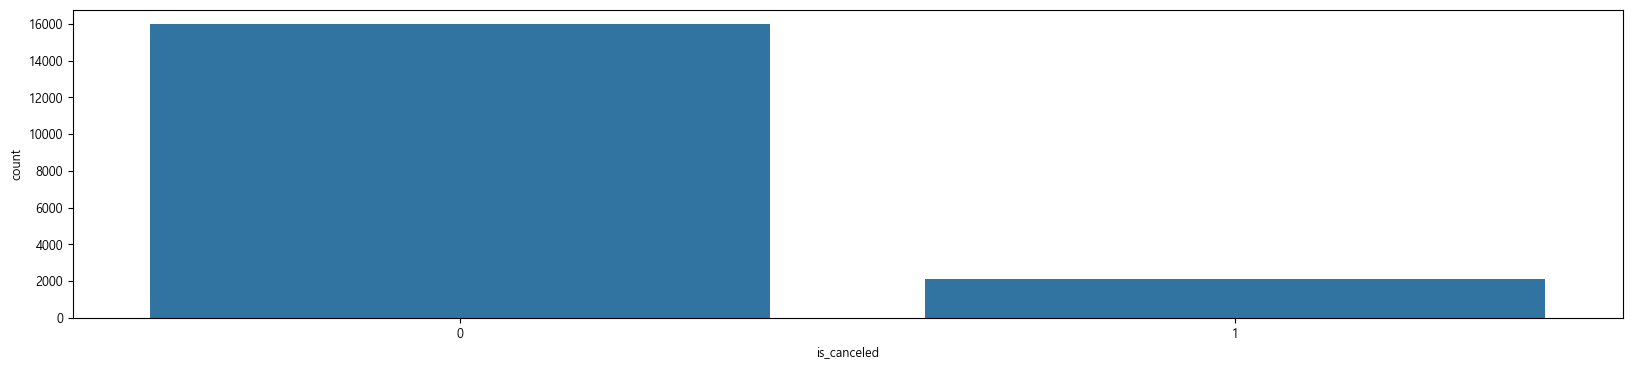

In [66]:
import seaborn as sns
sns.countplot(x='is_canceled', data=hotel2)
print(hotel2.is_canceled.value_counts())

print('''아래 차트에서 보는 바와 같이, 목적변수인 is_canceled의 클래스불균형이 큰 상태다.
      클래스 불균형을 처리하기 위해 아래 두 가지를 생각해볼 수 있다.
      1) 데이터가 많은 클래스에서 판별 기준에 직접적 영향을 주지 않는 데이터를 덜어내는 방법
        - BorderlineSMOTE (Syntetic Minority Oversampling 기법)  
      2) 데이터가 적은 클래스의 특성 집합과 유사한 데이터를 생성하는 방법
        - TomekLink 
''')

#### (6) 기법을 선정한 이유를 작성하고, 원데이터를 포함해 3개의 데이터 세트를 구성하시오.

In [118]:

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

hotel3 = hotel2.copy()

le = LabelEncoder()
hotel3.deposit_type = le.fit_transform(hotel3.deposit_type)
hotel3.is_canceled = hotel3.is_canceled.astype('int')
hotel3.is_repeated_guest = hotel3.is_repeated_guest.astype('int')

X = hotel3.drop('is_canceled', axis=1)
y = hotel3.is_canceled

#### (7) 오버 샘플링 데이터와 원데이터를 사용해 정확도 측면 모델 하나와 속도 측면의 모델 하나를 선정하고, 그 이유를 설명하시오.

In [128]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE

model_lr = LogisticRegression(C=0.05, solver='lbfgs', max_iter=1000, n_jobs=-1)
model_rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
model_names = ['LogisticRegression', 'RandomForest']
models = [model_lr, model_rf]

prep_sm = BorderlineSMOTE()
prep_tl = TomekLinks()
prep_names = ['BorderlineSMOTE', 'TomekLinks', 'original']
preps = [prep_sm, prep_tl, np.nan]

def estimate_models(model_names, models, prep_names, preps, X, y):
    index = 0
    repdf = pd.DataFrame()
    for i, (model_name, model) in enumerate(zip(model_names, models)):
        for j, (prep_name, prep) in enumerate(zip(prep_names, preps)):
            if prep_name != 'original':
                Xtmp, ytmp = prep.fit_resample(X, y)
                X_train, X_test, y_train, y_test = train_test_split(Xtmp, ytmp)
                model.fit(X_train, y_train)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
                model.fit(X_train, y_train)
            
            repdf.loc[index, 'preprocess'] = prep_name
            repdf.loc[index, 'model'] = model_name
            repdf.loc[index, 'score'] = model_lr.score(X_test, y_test)
            index += 1
    return repdf

repdf = estimate_models(model_names, models, prep_names, preps, X, y)
repdf

,preprocess,model,score
0,BorderlineSMOTE,LogisticRegression,0.676393
1,TomekLinks,LogisticRegression,0.918475
2,original,LogisticRegression,0.920930
3,BorderlineSMOTE,RandomForest,0.593363
4,TomekLinks,RandomForest,0.917789
5,original,RandomForest,0.925138


In [105]:
X.head(100)

,deposit_type,is_repeated_guest,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,0,0.0,105.0,2.0,5.0,0.0,0.0,1.0,0.0,131.500000
1,0,0.0,303.0,2.0,2.0,0.0,0.0,0.0,0.0,73.950000
2,0,0.0,33.0,2.0,3.0,0.0,0.0,0.0,0.0,78.246667
3,0,0.0,48.0,0.0,1.0,0.0,0.0,1.0,0.0,80.300000
5,0,0.0,116.0,2.0,4.0,0.0,0.0,0.0,0.0,88.400000
...,...,...,...,...,...,...,...,...,...,...
106,0,0.0,35.0,2.0,2.0,0.0,0.0,1.0,0.0,144.630000
107,0,0.0,4.0,2.0,3.0,0.0,0.0,0.0,0.0,27.000000
109,0,0.0,141.0,0.0,2.0,0.0,0.0,0.0,0.0,80.100000
110,0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,47.000000


### 2. 통계분석 (50점)

#### 1. 공장에서는 시제품의 농도(%)가 60이라고 주장하며 품질관리팀에서 10개의 샘플을 뽑았다. 유의수준 5%에서 다음을 검정하시오.

#### 2. 코로나 시계열 데이터로 다음을 수행하시오.

#### 3. 사회과학, 자연과학, 공학 세 개 학과의 평점조사표를 보고 학과와 성적이 관계있는지 검정하시오.